In [1]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

Imports

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the Data

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


Extract the Data containers

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


Problem1: Look at the Data

20


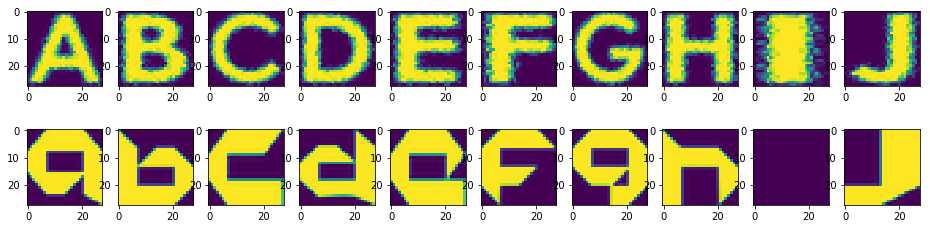

In [5]:
def print_selection(number: int) -> None:
  main_dir = os.listdir()
  #print(main_dir)
  small = os.listdir('notMNIST_small')
  large = os.listdir('notMNIST_large')
  #print(small, large)
  path = []
  for sub1 in ['notMNIST_small', 'notMNIST_large']:
    for sub2 in sorted(small):
      path.append(sub1+'/'+sub2)
  print(len(path))

  f, ax = plt.subplots(figsize=(16, 4))
  for i in range(len(path)):
    ax = plt.subplot(2, len(path)/2, i+1)
    #print(path[i] + '/' + os.listdir(path[i])[0])
    img=mpimg.imread(path[i] + '/' + os.listdir(path[i])[number])
    plt.imshow(img)
  return None

print_selection(0)

Transform into Datasets, safe as Pickles

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630303
Standard deviation: 0.45449105
Pickling .\notMNIST_large\C.pickle.
.\notMNIST_large\C
Full dataset tensor: (52912, 

Problem2: Look at Data in Datasets

['.git', '.gitignore', '.ipynb_checkpoints', 'notMNIST_large', 'notMNIST_large.tar.gz', 'notMNIST_small', 'notMNIST_small.tar.gz', 'UdacityDL1_Assignment1.ipynb', 'UdacityDL1_Assignment2.ipynb', 'UdacityDL1_Assignment3.ipynb']
['A', 'A.pickle', 'B', 'B.pickle', 'C', 'C.pickle', 'D', 'D.pickle', 'E', 'E.pickle', 'F', 'F.pickle', 'G', 'G.pickle', 'H', 'H.pickle', 'I', 'I.pickle', 'J', 'J.pickle'] ['A', 'A.pickle', 'B', 'B.pickle', 'C', 'C.pickle', 'D', 'D.pickle', 'E', 'E.pickle', 'F', 'F.pickle', 'G', 'G.pickle', 'H', 'H.pickle', 'I', 'I.pickle', 'J', 'J.pickle']
notMNIST_small/A


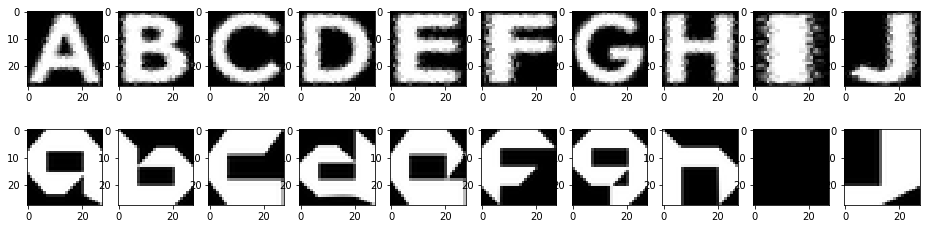

In [7]:
main_dir = os.listdir()
print(main_dir)
small = os.listdir('notMNIST_small')
large = os.listdir('notMNIST_large')
print(sorted(small), sorted(large))
path = []
for sub1 in ['notMNIST_small', 'notMNIST_large']:
  for sub2 in sorted(small):
    path.append(sub1+'/'+sub2)
print(path[0])

f, ax = plt.subplots(figsize=(16, 4))
for i in range(1, 40, 2):
  ax = plt.subplot(2, 10, (i+1)/2)
  with open(path[i], 'rb') as pickle_file:
    content = pickle.load(pickle_file)
  plt.imshow(content[0], cmap='gray')
plt.show()

Problem3: Check if Data is balanced

In [8]:
main_dir = os.listdir()
small = os.listdir('notMNIST_small')
large = os.listdir('notMNIST_large')
path = []
for sub1 in ['notMNIST_small', 'notMNIST_large']:
  for sub2 in sorted(small):
    path.append(sub1+'/'+sub2)

for i in range(1, 40, 2):
  with open(path[i], 'rb') as pickle_file:
    content = pickle.load(pickle_file)
    print(path[i], content.shape[0])
print('\nLooks Balanced!')

notMNIST_small/A.pickle 1872
notMNIST_small/B.pickle 1873
notMNIST_small/C.pickle 1873
notMNIST_small/D.pickle 1873
notMNIST_small/E.pickle 1873
notMNIST_small/F.pickle 1872
notMNIST_small/G.pickle 1872
notMNIST_small/H.pickle 1872
notMNIST_small/I.pickle 1872
notMNIST_small/J.pickle 1872
notMNIST_large/A.pickle 52909
notMNIST_large/B.pickle 52911
notMNIST_large/C.pickle 52912
notMNIST_large/D.pickle 52911
notMNIST_large/E.pickle 52912
notMNIST_large/F.pickle 52912
notMNIST_large/G.pickle 52912
notMNIST_large/H.pickle 52912
notMNIST_large/I.pickle 52912
notMNIST_large/J.pickle 52911

Looks Balanced!


Train Test Val Split

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 50000
valid_size = 15000
test_size = 15000

valid_dataset, valid_labels, train_dataset, train_labels = \
    merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = \
    merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (50000, 28, 28) (50000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


Shuffling

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Problem4: Data and Label Matching after shuffling?

Training: (50000, 28, 28) (50000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


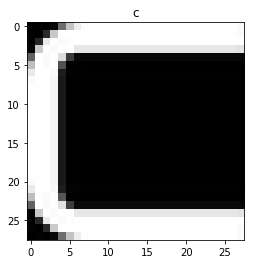

In [11]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

i = 11111
mylabels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
plt.imshow(train_dataset[i], cmap='gray')
plt.title(mylabels[train_labels[i]])
plt.show()

Save Data for later use

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 251200502


In [13]:
# flatten matrices
train_dataset = train_dataset.reshape((len(train_dataset), 28*28))
test_dataset = test_dataset.reshape((len(test_dataset), 28*28))
valid_dataset = valid_dataset.reshape((len(valid_dataset), 28*28))

Problem5: Measure Overlap in Train, Test and Val Sets <br/>

(opt1: near duplicates?)<br/>
(opt2: create cleaned version and compare)

In [ ]:
#from tqdm import tqdm_notebook as tqdm # not supported in colabs
from tqdm import tqdm

## VERY slow loop!! ~20mins on colab
overlap_test = np.zeros(len(train_dataset))
overlap_valid = np.zeros(len(train_dataset))

with tqdm(total=len(test_dataset)) as pbar:
  for i,item in enumerate(train_dataset):
    if item in test_dataset:
      overlap_test[i] = 1
    else:
      pass
    pbar.update()
    
with tqdm(total=len(test_dataset)) as pbar:
  for i,item in enumerate(valid_dataset):
    if matrix in valid_dataset:
      overlap_valid[i] = 1
    else:
      pass
    pbar.update()


#dict_test = {}
#dict_valid = {}

 79%|████████████████████████████▍       | 11854/15000 [02:47<00:47, 65.95it/s]

In [ ]:
np.sum(overlap_test), np.sum(overlap_valid)
overlap_test[:10]

Problem 6: 

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

In [ ]:
LR1 = LR()
#y_pred = LR1.fit(train_dataset[:50], train_labels[:50]).predict(test_dataset[:50])
scores = LR1.fit(train_dataset[:50], train_labels[:50]).score(test_dataset[:50], test_labels[:50])
print(scores)

In [ ]:
LR2 = LR()
#y_pred = LR2.fit(train_dataset[:100], train_labels[:100]).predict(test_dataset[:100])
scores = LR2.fit(train_dataset[:100], train_labels[:100]).score(test_dataset[:100], test_labels[:100])
print(scores)

In [ ]:
LR3 = LR()
#y_pred = LR3.fit(train_dataset[:1000], train_labels[:1000]).predict(test_dataset[:1000])
scores = LR3.fit(train_dataset[:1000], train_labels[:1000]).score(test_dataset[:1000], test_labels[:1000])
print(scores)

In [ ]:
LR4 = LR()
#y_pred = LR4.fit(train_dataset[:5000], train_labels[:5000]).predict(test_dataset[:5000])
scores = LR4.fit(train_dataset[:5000], train_labels[:5000]).score(test_dataset[:5000], test_labels[:5000])
print(scores)

In [ ]:
LR5 = LR()
#y_pred = LR5.fit(train_dataset, train_labels).predict(test_dataset)
scores = LR5.fit(train_dataset, train_labels).score(test_dataset, test_labels)
print(scores)